# __DOC EMBEDDING EXP#1__

In [147]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from gensim import corpora
from nltk.corpus import stopwords
from fse.models import Average
from fse import IndexedList
import sklearn.decomposition
import sklearn.manifold
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

In [83]:
speech = pd.read_csv('./dataset/archive/presidential_speeches.csv')
# one presentation has no transcript so I drop it
speech = speech[pd.isna(speech['Transcript']) == False]
# reset the index
speech.reset_index(drop=True, inplace=True)

In [29]:
speech.head(5)

,Date,President,Party,Speech Title,Summary,Transcript,URL
0,1789-04-30,George Washington,Unaffiliated,First Inaugural Address,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...
1,1789-10-03,George Washington,Unaffiliated,Thanksgiving Proclamation,"At the request of Congress, Washington establi...",Whereas it is the duty of all Nations to ackno...,https://millercenter.org/the-presidency/presid...
2,1790-01-08,George Washington,Unaffiliated,First Annual Message to Congress,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
3,1790-12-08,George Washington,Unaffiliated,Second Annual Message to Congress,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
4,1790-12-29,George Washington,Unaffiliated,Talk to the Chiefs and Counselors of the Senec...,The President reassures the Seneca Nation that...,"I the President of the United States, by my ow...",https://millercenter.org/the-presidency/presid...


In [33]:
# I haven't found any good pretrained doc2vec model that we can use, so I just trained a new one using our transcripts

# create and clean the corpus
corpus = speech['Transcript'].values
texts = [[word.lower() for word in doc.split() if word not in stopwords.words('english')] for doc in corpus]
# develop a word2vec model first
w2vmodel = Word2Vec(texts, vector_size=100, window=10)
# use FastText to train doc2vec
d2vmodel = Average(w2vmodel)
d2vmodel.train(IndexedList(texts))

(991, 1935382)

In [42]:
print(f'The size of the document embedding space is: {d2vmodel.sv[0].shape[0]}')

The size of the document embedding space is: 100


In [59]:
# encode president names to numbers
presidents_names = list(set(speech.President.values))
labels = [presidents_names.index(name) for name in speech.President.values]

In [61]:
# T-SNE
tsneDoc = sklearn.manifold.TSNE(n_components=2).fit_transform(d2vmodel.sv.vectors)

/Users/shiyang/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/shiyang/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


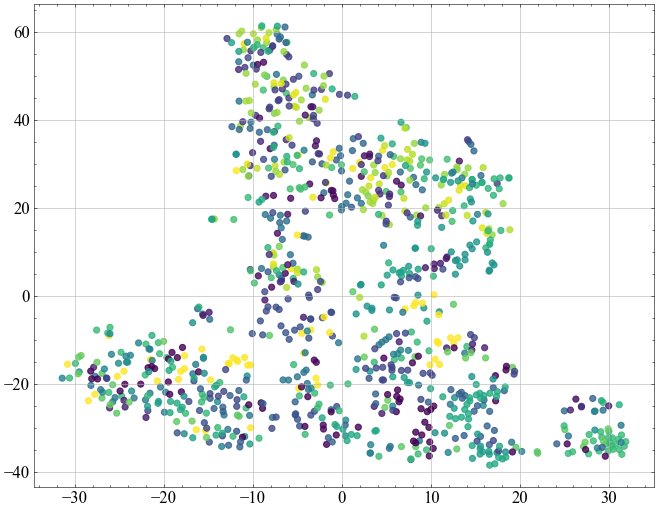

In [74]:
# visualize the embedding
plt.style.use(['nature', 'science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(tsneDoc[:, 0], tsneDoc[:, 1], c=labels, s=30, alpha=0.8, label=presidents_names)
# plt.legend()
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [156]:
# # label via context
context = pd.read_csv('./dataset/archive/presidential_speeches_manual_labels.csv')
speech = pd.merge(speech, context[['URL', 'Context']], on='URL', how='inner')
context_names = list(set(speech.Context.values))
labels = [context_names.index(name) for name in speech.Context.values]

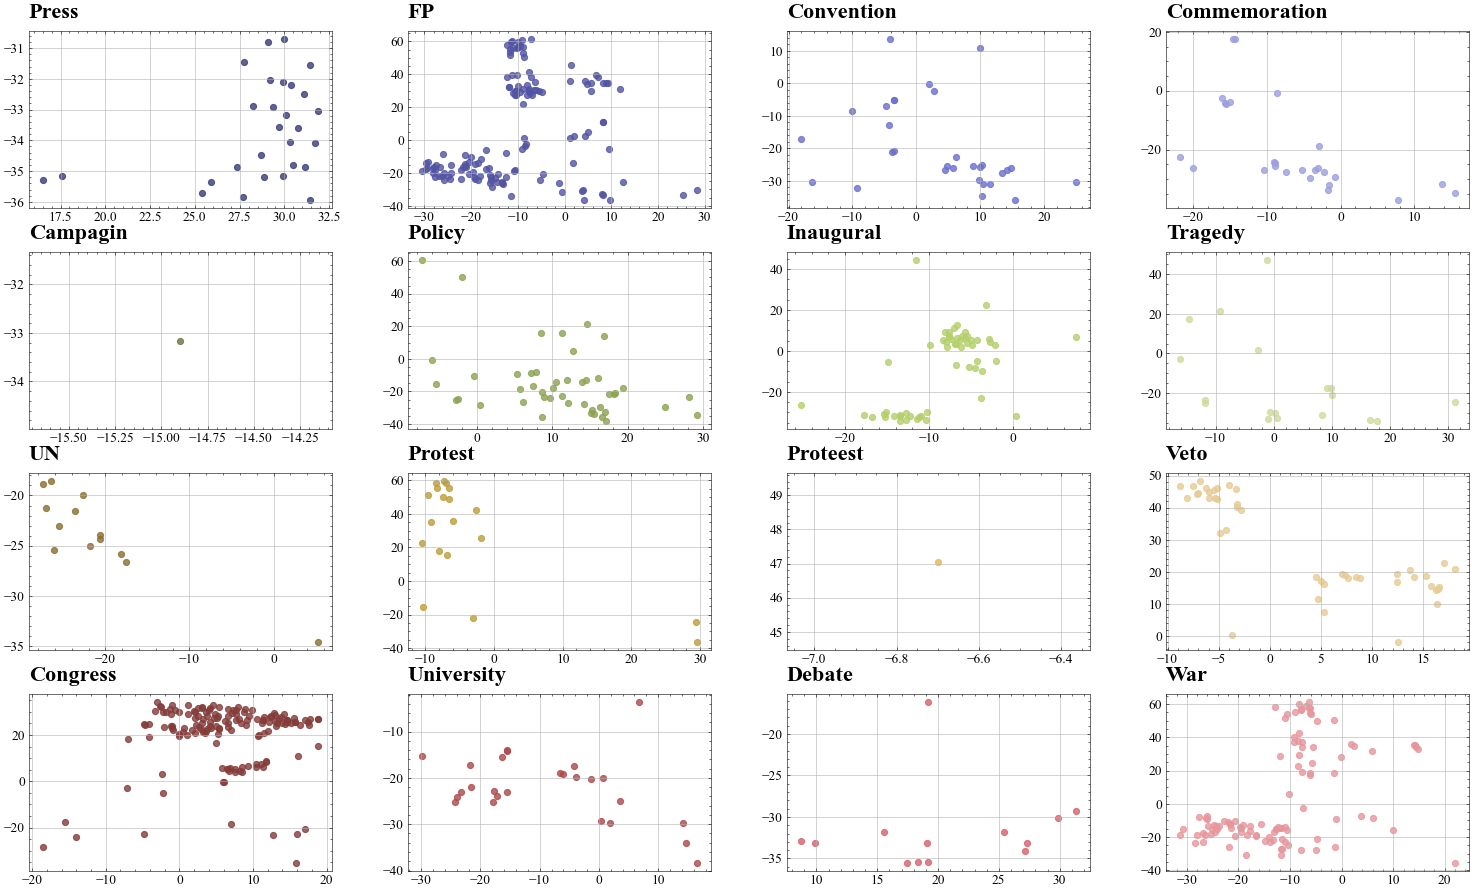

In [157]:
# visualize the embedding
fig, axis = plt.subplots(4, 4, figsize=(20, 15), dpi=80)
context_names = context_names[1:]
cmap = cm.get_cmap('tab20b')
colors = cmap.colors
for i, context_name in enumerate(context_names):
    x_index = speech[speech.Context == context_name].index.values
    axis[i//4, i%4].set_title(context_name, loc = 'left', fontsize=20, pad=12, fontweight ="bold")
    axis[i//4, i%4].scatter(tsneDoc[x_index, 0], tsneDoc[x_index, 1], color=colors[i], s=30, alpha=0.8, label=context_name)
    axis[i//4, i%4].tick_params(axis='both', which='major', labelsize=12)
    axis[i//4, i%4].grid()
    if i == 15:
        break
        
plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.25, hspace=0.25)
plt.show()

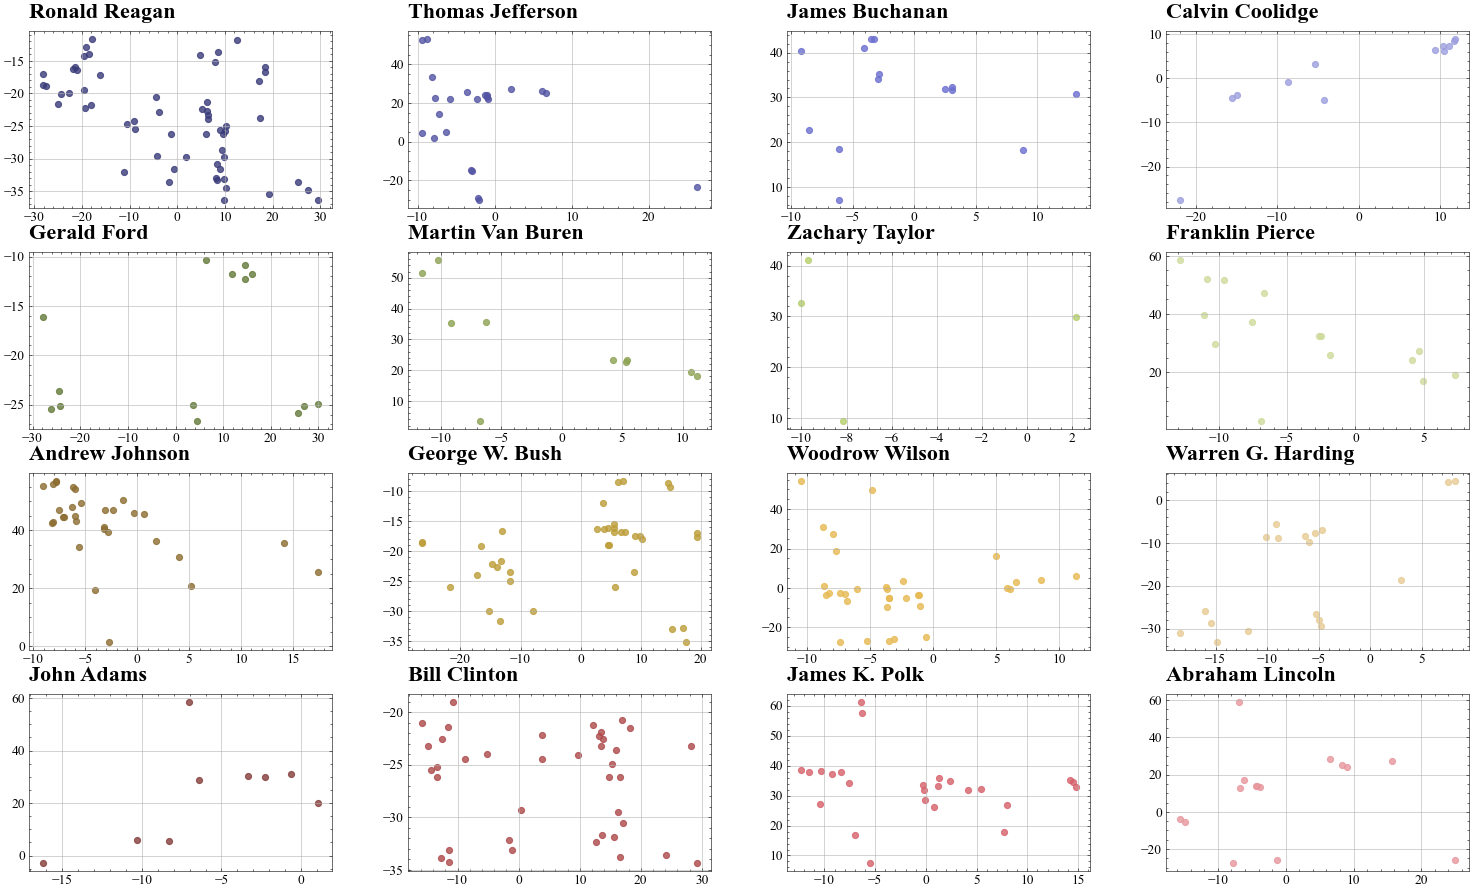

In [166]:
# encode president names to numbers
presidents_names = list(set(speech.President.values))
labels = [presidents_names.index(name) for name in speech.President.values]
fig, axis = plt.subplots(4, 4, figsize=(20, 15), dpi=80)
cmap = cm.get_cmap('tab20b')
colors = cmap.colors
for i, president_name in enumerate(presidents_names):
    x_index = speech[speech.President == president_name].index.values
    axis[i//4, i%4].set_title(president_name, loc = 'left', fontsize=20, pad=12, fontweight ="bold")
    axis[i//4, i%4].scatter(tsneDoc[x_index, 0], tsneDoc[x_index, 1], color=colors[i], s=30, alpha=0.8, label=president_name)
    axis[i//4, i%4].tick_params(axis='both', which='major', labelsize=12)
    axis[i//4, i%4].grid()
    if i == 15:
        break
        
plt.subplots_adjust(left=0, bottom=0.1, right=0.9, top=0.8, wspace=0.25, hspace=0.25)
plt.show()

In [174]:
# speech['fasttext_emb'] = [vec for vec in d2vmodel.sv.vectors]
speech.to_csv('speech_with_emb.csv')

,Date,President,Party,Speech Title,Summary,Transcript,URL,Context,fasttext_emb
0,1789-04-30,George Washington,Unaffiliated,First Inaugural Address,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...,Inaugural,"[0.22561753, 0.14036061, -0.1481158, -0.263259..."
1,1789-10-03,George Washington,Unaffiliated,Thanksgiving Proclamation,"At the request of Congress, Washington establi...",Whereas it is the duty of all Nations to ackno...,https://millercenter.org/the-presidency/presid...,NaN,"[0.3033993, 0.1814788, -0.19653948, -0.1932780..."
2,1790-01-08,George Washington,Unaffiliated,First Annual Message to Congress,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,Congress,"[0.14356987, 0.21193929, -0.025735615, -0.2010..."
3,1790-12-08,George Washington,Unaffiliated,Second Annual Message to Congress,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,Congress,"[0.1565068, 0.2119076, -0.016188525, -0.158311..."
4,1790-12-29,George Washington,Unaffiliated,Talk to the Chiefs and Counselors of the Senec...,The President reassures the Seneca Nation that...,"I the President of the United States, by my ow...",https://millercenter.org/the-presidency/presid...,Native,"[0.11879008, 0.11735182, -0.16825187, -0.24355..."
...,...,...,...,...,...,...,...,...,...
986,2019-01-19,Donald Trump,Republican,Remarks about the US Southern Border,President Donald Trump speaks about what he se...,"Just a short time ago, I had the honor of pres...",https://millercenter.org/the-presidency/presid...,Policy,"[-0.049278017, 0.046519816, 0.19544134, 0.0527..."
987,2019-02-05,Donald Trump,Republican,State of the Union Address,"In his second State of the Union Address, Pres...","Madam Speaker, Mr. Vice President, Members of ...",https://millercenter.org/the-presidency/presid...,SOTU,"[-0.07658558, -0.06376522, 0.16848977, 0.13982..."
988,2019-02-15,Donald Trump,Republican,Speech Declaring a National Emergency,President Donald Trump declares a national eme...,"Thank you very much, everybody. Before we begi...",https://millercenter.org/the-presidency/presid...,Policy,"[-0.14047179, -0.1524901, 0.2145785, 0.0730596..."
989,2019-09-24,Donald Trump,Republican,Remarks at the United Nations General Assembly,President Donald Trump speaks to the 74th sess...,"Thank you very much. Mr. President, Mr. Secret...",https://millercenter.org/the-presidency/presid...,UN,"[-0.054737996, -0.13411714, 0.18593867, -0.092..."
